In [1]:
exec(open("init_notebook.py", "r").read())
%load_ext autoreload
%autoreload 2

current working dirC:\AV\Carla\CARLA_0.9.13\WindowsNoEditor\PythonAPI\experiments


In [2]:
from shapely.geometry import Polygon, Point, LineString
from shapely.affinity import rotate
import matplotlib.pyplot as plt
import math
import random
import seaborn as sb
import numpy as np
from collections import *
from typing import *
import pandas as pd

from tqdm import tqdm
import seaborn as sns
sns.set_theme()
# from agents.pedestrians.destination import CrosswalkGeometry

In [3]:
class CrosswalkGeometry:
    '''
    Geometric information of CrosswalkModel, including source, idealDestination, areaPolygon, and goalLine.

    CONSTANTS:
        MAX_ABSOLUTE_DEGREE: float
        MAX_RELATIVE_DEGREE: float
        INTER_POINTS_NUM: int
        INTER_POINTS_DISTANCE_MOD: float
    '''
    MAX_ABSOLUTE_DEGREE = math.radians(60)
    MAX_RELATIVE_DEGREE = math.radians(45)
    INTER_POINTS_NUM = 3
    INTER_POINTS_DISTANCE_MOD = 1.5

    def __init__(self, source: Point, idealDestination: Point=None, areaPolygon: Polygon=None, goalLine: LineString=None, latDirectionChangeProb=0.5):
        self.source = source
        self.idealDestination = idealDestination
        self.areaPolygon = areaPolygon
        self.goalLine = goalLine
        self.intermediatePoints = []
        self.latDirectionChangeProb = latDirectionChangeProb
        self._lastWaypointLatDirection = random.choice([-1, 1]) #lateral direction 
        self.finalDestination = None
        self.nextIntermediatePointIdx = None
        if self.areaPolygon == None:
            self.createPolygonIfNone()
        self.generateIntermediatePoints()
    
    def createPolygonIfNone(self):
        # TODO: we make a generic one which may be based on real world dataset. Also create a goal line
        if self.goalLine == None:
            self.createGoalLine(4)
       
        self.areaPolygon = self.genPolyArea(self.source, self.idealDestination, self.goalLine)


    def genPolyArea(self, start: Point, end: Point, goalLine: LineString):
        '''
        Generate a generic areaPolygon given a start point, end point and a goalLine.
        
        Args:
            start (shapely.geometry.Point): the point where the pedestrian enters the crosswalk.
            end (shapely.geometry.Point): the ideal point where the pedestrian exits the crosswalk.
            goalLine (shapely.geometry.LineString): the sidewalk which contains the end point.

        Returns:
            areaPolygon (shapely.geometry.Polygon): the generated polygon that forms the area of an abstract crosswalk space.
        '''
        # Extract goalLine information
        goalLine_x1, goalLine_y1 = goalLine.coords[0][0], goalLine.coords[0][1] 
        goalLine_x2, goalLine_y2 = goalLine.coords[1][0], goalLine.coords[1][1]
        # Generate base as perpendicular to the vertical line
        
        if end is None:
            end = self.closestEnd(start, goalLine)
            
        verticalLine = LineString([start, end])
        baseRight = rotate(verticalLine, -90, origin=start)
        baseLeft = rotate(verticalLine, 90, origin=start)
        # Bottom left point
        botLeft = baseLeft.interpolate(0.5, normalized=False)
        botLeft_x = botLeft.coords[0][0]
        botLeft_y = botLeft.coords[0][1]
        # Bottom right point
        botRight = baseRight.interpolate(0.5, normalized=False)
        botRight_x = botRight.coords[0][0]
        botRight_y = botRight.coords[0][1]
        # Top left point
        topLeft_x = goalLine_x1
        topLeft_y = goalLine_y1
        topLeft = Point((topLeft_x, topLeft_y))
        # Top right point
        topRight_x = goalLine_x2
        topRight_y = goalLine_y2
        topRight = Point((topRight_x, topRight_y))
        # Mid left point
        midLeft_x = min(botLeft_x, topLeft_x) + (max(botLeft_x, topLeft_x) - min(botLeft_x, topLeft_x))/1.5
        midLeft_y = (topLeft_y - botLeft_y)/2
        midLeft = Point((midLeft_x, midLeft_y))
        # Mid right point
        midRight_x = min(botRight_x, topRight_x) + (max(botRight_x, topRight_x) - min(botRight_x, topRight_x))/3
        midRight_y = (topRight_y - botRight_y) / 2
        midRight = Point((midRight_x, midRight_y))

        # Build areaPolygon
        areaPolygon = Polygon([botLeft, midLeft, topLeft, topRight, midRight, botRight])
        return areaPolygon


    def generateIntermediatePoints(self, maxAbsDegree=MAX_ABSOLUTE_DEGREE, maxDeltaDegree=MAX_RELATIVE_DEGREE, nInterPoints=INTER_POINTS_NUM, maxInterPointsDistance=INTER_POINTS_DISTANCE_MOD, sampleIdealDestination=False):
        '''
        Generate intermediate points inside the crosswalk area to form pedestrian crossing trajectories. 

        Args:
            maxAbsDegree (float): the maximum degree between the new line and the vertical line that shares the same start point
            maxDeltaDegree (float): the maximum degree between the new line and the extended previous line. The end point of the previous line is the start point of the new line
            nInterPoints (int): the number of intermediates points to be generated
            maxInterPointsDistance (float): the scalar modifier for the max distance between any two intermediate points

        Returns:
            None
        '''
        if sampleIdealDestination:
            self.idealDestination = self.sampleDestinationOnGoalLine()
            
        start = self.source
        if self.idealDestination is None:
            # Find vertical line
            D_final = self.closestEnd(start, self.goalLine)
        else:
            D_final = self.idealDestination
            
        # set last direction towards the destination
        xDiff = (D_final.x - start.x)
        if xDiff == 0:
            xDiff = 0.001
        slope = (D_final.y - start.y) / xDiff
        if slope > 0:
            self._lastWaypointLatDirection = 1
        else:
            self._lastWaypointLatDirection = -1
            
        crosswalk = self.areaPolygon
        waypoints = [start]
        
        for i in range(nInterPoints):
            W_pre1 = waypoints[-1]
            W_pre2 = waypoints[-2] if len(waypoints) > 1 else None
            
            pointsOL = self.pointsOnLine(W_pre1, D_final, nInterPoints-i)
            A = pointsOL[1]
            B = pointsOL[2]
            
            # print("W_pre1", W_pre1, "A", A, "B", B)
            done = False
            
            maxTries = 100 * nInterPoints
            while (not done and maxTries > 0):
                maxTries -= 1
                C = self.pointBetween(A, B, d=random.uniform(0, 1)) # modify d if needed
                CRotAngle, CDirection = self.getNextRotation()
                C = self.pointRotate(C, A, degree=CRotAngle)    
                # Check constraints
                if crosswalk.contains(C):
                    if i == 0:
                        done = True
                        break
                    # print(f"C, {C} inside the area")
                    lineAB = LineString([A, B])
                    line_W_pre1_C = LineString([W_pre1, C])
                    line_W_pre1_W_pre2 = None
                    if W_pre2 is not None:
                        line_W_pre1_W_pre2 = LineString([W_pre2, W_pre1])
                    if line_W_pre1_C.length <= lineAB.length*maxInterPointsDistance:
                        # print(f"line_W_pre1_C.length, {line_W_pre1_C.length} is good")
                        # if the ideal destination is None, we are free to explore

                        if self.idealDestination is None:
                            # Find vertical line
                            D_final = self.closestEnd(W_pre1, self.goalLine)
                            # print(f"ideal destination is None, D_final is {D_final}")
                        else:
                            D_final = self.idealDestination

                        destinationLine = LineString([W_pre1, D_final])


                        # Calculate the angle between the new line and the vertical line
                        a_theta = self.degreeFromX(destinationLine) - self.degreeFromX(line_W_pre1_C)
                        # Calculate the angle between the new line and the extended previous line
                        if line_W_pre1_W_pre2 is None:
                            d_theta = 0
                        else:
                            d_theta = self.degreeFromX(line_W_pre1_W_pre2) - self.degreeFromX(line_W_pre1_C)


                        if maxAbsDegree*(-1) <= a_theta <= maxAbsDegree and maxDeltaDegree*(-1) <= d_theta <= maxDeltaDegree:
                            done = True
                        # else:
                        #     print("a_theta", math.degrees(a_theta), "b_theta", math.degrees(d_theta))
                        #     waypoints.append(C)
                        #     print("returning to debug")
                        #     return waypoints
                    # else:
                    #     print(f"line_W_pre1_C.length, {line_W_pre1_C.length} is bad")
                    #     waypoints.append(C)
                    #     print("returning to debug")
                    #     return waypoints
                        
            
            # print(f"iteration-{i}, C, {C} satisfies the constraints")
            if done:
                self._lastWaypointLatDirection = CDirection
                waypoints.append(C)

        # fiCDirection rotate to find end point is different
    
        if self.idealDestination is not None:
            # Find vertical line
            waypoints.append(self.idealDestination)
        else:
        
            D_final = self.closestEnd(W_pre1, self.goalLine)

            # Final destination point works in the reversed direction. We get the D_final and ...

            final_start = D_final
            final_end = waypoints[-1]
            done = False
            maxTries = 100 * nInterPoints
            while (not done and maxTries > 0):
                maxTries -= 1
                
                C = self.pointBetween(final_start, final_end, d=random.uniform(0, 1))
                
                CRotAngle, CDirection = self.getNextRotation()
                C = self.pointRotate(C, final_start, degree=-CRotAngle) # in case of the final, we are rotating around B. So, RotAngle will be reversed.

                segment = LineString([final_start, final_end])
                line_W_pre1_C = LineString([waypoints[-1], C])
                line_W_pre1_W_pre2 = LineString([waypoints[-2], waypoints[-1]])
                if line_W_pre1_C.length <= segment.length*maxInterPointsDistance:
                    # Find vertical line
                    vert_start = waypoints[-1]
                    vert_end = self.closestEnd(vert_start, self.goalLine)
                    destinationLine = LineString([vert_start, vert_end])
                    # Calculate the angle between the new line and the vertical line
                    a_theta = self.degreeFromX(destinationLine) - self.degreeFromX(line_W_pre1_C)
                    # Calculate the angle between the new line and the extended previous line
                    d_theta = self.degreeFromX(line_W_pre1_W_pre2) - self.degreeFromX(line_W_pre1_C)

                    if abs(a_theta) <= maxAbsDegree and abs(d_theta) <= maxDeltaDegree:
                        done = True

            if self.goalLine.contains(C) == False:
                C = self.closestEnd(C, self.goalLine)
            waypoints.append(C)
            
        # 1. set intermediatePoints[] to the generated waypoints[]
        self.intermediatePoints = waypoints[1:]

        # 2. set nextIntermediatePointIdx to index 0
        self.nextIntermediatePointIdx = 0

        # 3. set self.finalDestination to the last item in waypoints[]
        self.finalDestination = waypoints[-1]

        return self.intermediatePoints




    # region 
    def degreeFromX(self, line: LineString): # TODO move to lib/Geometry
        """
        Find the angle in radian between a given line and the x-axis.
        
        Args:
            line (shapely.LineString): a line

        Returns:
            theta (float): angle in radians
        """
        # Extract points from line1 and line2
        x = line.coords[1][0] - line.coords[0][0]
        y = line.coords[1][1] - line.coords[0][1]

        # Find theta using formula
        theta = math.atan2(y, x)

        return theta

    def closestEnd(self, point: Point, goalLine: LineString):
        """
        Given a point A and a line Y, find the point B on Y such that the line AB is the shortest.

        Args:
            point (shapely.geometry.Point): point A
            goalLine (shapely.geometry.LineString): line Y

        Returns:
            end (shapely.geometry.Point): point B
        """
        d = goalLine.project(point)
        end = goalLine.interpolate(d)
        return end

    def pointBetween(self, start: Point, end: Point, d: float):
        """
        Given point A and point B, find a point C in between AB that is d distance away from A.
        
        Args:
            start (shapely.geometry.Point): point A
            end (shapely.geometry.Point): point B
            d (float): a scalar multiplier to the normalized distance between point A and point B

        Returns:
            point (shapely.geometry.Point): point C
        """
        line = LineString([start, end])
        point = line.interpolate(d, normalized=True)
        return point

    def pointRotate(self, point: Point, origin: Point, degree=90):
        """
        Given a point A and an origin O, rotate A +-90 degrees around O to get point B.

        Args:
            point (shapely.geometry.Point): point A
            origin (shapely.geometry.Point): point O
            degree (int, optional): degree of rotation. Defaults to 90

        Returns:
            rotated_point (shapely.geometry.Point): point B
        """
        rotated_point = rotate(point, degree, origin=origin)
        return rotated_point

    def pointsOnLine(self, start: Point, end: Point, n: int, excludeEnds=False):
        """
        Given a start point A and an end point B, generate n number of evenly spaced points between the line AB.

        Args:
            start (shapely.geometry.Point): point A
            end (shapely.geometry.Point): point B
            n (int): number of points between the line AB

        Returns:
            pointsOL[(shapely.geometry.Point)]: the array of generated points between AB
        """
        pointsOL = [start]
        line = LineString([start, end])
        gap = 1 / (n+1)
        d = gap
        for i in range(n):
            point = line.interpolate(d, normalized=True)
            d = d + gap
            pointsOL.append(point)
        pointsOL.append(end)
        
        # print("pointsOL", pointsOL)
        
        if excludeEnds:
            # print("pointsOL", pointsOL)
            # for p in pointsOL:
            #     print(p)
            return pointsOL[1:len(pointsOL)-1]
        return pointsOL
    
    def getNextRotation(self) -> Tuple[int, int]:
        """degree and lateral direction"""
        
        changeDirection = np.random.choice([True, False], p=[self.latDirectionChangeProb, 1-self.latDirectionChangeProb])
        nextDirection = self._lastWaypointLatDirection
        if changeDirection:
            nextDirection *= -1
        return nextDirection * 90, nextDirection
    
    def sampleDestinationOnGoalLine(self) -> Point:
        gap = random.uniform(0, 1)
        return self.goalLine.interpolate(gap, normalized=True)
        
        
    # endregion

In [4]:
def plotPoly(poly: Polygon):
    
    X, Y = poly.exterior.xy
    X.insert(0,0)
    Y.insert(0,0)
    X[-1] = 0
    Y[-1] = 0
    plt.fill(X, Y)
    plt.show()
    
def getPolygonFromTrajectories(trajectories: List[List[Point]]) -> Polygon:
    """ This function gets the x, y values as seperate lists and generates an envelops at 1 meter breaks on the y axis"""
    yXVals = defaultdict(lambda : [])
    for traj in trajectories:
        for point in traj:
            x, y = point.x, point.y
            # y = round(y, 1)
            # yFloor = math.floor(y)
            # if y < yFloor + 0.25:
            #     y = yFloor
            # elif y < yFloor + 0.75:
            #     y = yFloor + 0.5
            # else:
            #     y = yFloor + 1
            y = round(y)
            yXVals[y].append(x)

    ySorted = sorted(yXVals.keys())
    if ySorted[0] == 0:
        ySorted = ySorted[1:]
        del yXVals[0]
    # print(ySorted)
    # we go up on min, and down on max x vals
    minXVals = [min(yXVals[y]) for y in ySorted]
    maxXVals = [max(yXVals[y]) for y in ySorted]

    # print(minXVals, maxXVals)

    minPoints = list(zip(minXVals, ySorted))
    maxPoints = list(zip(maxXVals, ySorted))
    maxPoints.reverse()

    poly = Polygon(minPoints + maxPoints)
    
    # plotPoly(poly)
    return poly

def getIOUAreas(areaPolygon: Polygon, generatedTrajectoryEnvelope: Polygon) -> Tuple[float, float]:
    intersection = areaPolygon.intersection(generatedTrajectoryEnvelope)
    intersectionArea = intersection.area
    differenceFromIntersection = generatedTrajectoryEnvelope.difference(intersection)
    # plotPoly(intersection)
    # plotPoly(differenceFromIntersection)
    return intersection.area, differenceFromIntersection.area

def getIOUAreasPercentage(areaPolygon: Polygon, generatedTrajectoryEnvelope: Polygon) -> Tuple[float, float]:
    intersectionArea, differenceFromIntersectionArea = getIOUAreas(areaPolygon, generatedTrajectoryEnvelope)
    return (intersectionArea * 100) / areaPolygon.area, (differenceFromIntersectionArea * 100) / generatedTrajectoryEnvelope.area

# length of the paths in a single area is a metric for diversity
def trajToXY(trajectory: List[Point]) -> Tuple[List[float], List[float]]:
    X = []
    Y = []
    for point in trajectory:
        X.append(point.x)
        Y.append(point.y)
    return X, Y

def trajLen(trajectory: List[Point]) -> float:
    s = 0
    prev = None
    for point in trajectory:
        if prev is None:
            prev = point
            continue
        s += math.sqrt((prev.x - point.x) ** 2 + (prev.y - point.y) ** 2)
        prev = point
    return s

def getTrajectoryLengths(polygonIdx, evalData) -> Tuple[List[float], Dict[int, List[float]]]:
    """returns all lengths in a list and a dictionary where lengths are grouped by number of waypoints"""

    trajsByNWP = {}
    inDConf = inDConfigurations[polygonIdx]

    singlePolyTrajectoriesByNWaypoints = defaultdict(lambda : [])
    for trajPerStart in evalData:
        byWaypoints = evalData[trajPerStart]["trajectoriesByNumWaypoints"]
        for nIntermediate in byWaypoints:
            trajectoriesByPolygon = byWaypoints[nIntermediate]
            singlePolyTrajectoriesByNWaypoints[nIntermediate].extend(trajectoriesByPolygon[polygonIdx])

    allLengths = []
    lengthByNWaypoints = defaultdict(lambda : [])
    for nIntermediate in singlePolyTrajectoriesByNWaypoints:
        trajectories = singlePolyTrajectoriesByNWaypoints[nIntermediate]
        for trajectory in trajectories:
            l = trajLen(trajectory)
            # print("length", l)
            # break
            allLengths.append(l)
            lengthByNWaypoints[nIntermediate].append(l)
    return allLengths, lengthByNWaypoints
    

In [5]:
# Plot functions
def heatmap(trajectories: List[List[Point]], xLabel:str, yLabel:str, figsize=(20, 7)):
    plt.figure(figsize=figsize)
    X = []
    Y = []
    for traj in trajectories:
        Xt, Yt = trajToXY(traj)
        X += Xt
        Y += Yt

    data["X"] = X
    data["Y"] = Y
    sns.displot(data, x="X", y="Y")
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.show()

def routeLengthHistogram(trajectories: List[List[Point]], maxLinearDistance:float, figsize=(20, 7)):
    plt.figure(figsize=figsize)
    allLengths = [trajLen(traj) for traj in trajectories]
    # print(allLengths)

    plt.figure(figsize=(20, 7))
    sns.histplot(allLengths)
    plt.vlines(maxLinearDistance, 0, 90, colors='green', linestyles='solid', linewidth=3, label='Maximum Linear Route')
    # plt.title("Frequence distribution of Route length in a 6-meter wide segment with one end points")

    plt.xlabel("Length of route")
    # plt.ylabel("Envelope Coverage(%)")
    plt.legend()
    plt.show()
    # sns.boxplot(allLengths)

In [6]:
def sampler(
    areaPolygon: Polygon,
    goalLine: LineString,
    startLine: LineString,
    
    latDirectionChangeProb: float,
    nIntermediate: int, 
    trajPerStart: int, 
    maxAbsDegree: int, 
    maxDeltaDegree: int,
    nStartPoints: int,
    startPoint: Point= None,
    nEndPoints: int = None,
    endPoint:Point = None,
    plot=True
) -> Tuple[Dict[str, List[int]], List[List[Point]]] : 
    
    maxAbsDegree = math.radians(maxAbsDegree)
    maxDeltaDegree = math.radians(maxDeltaDegree)
    
    startPoints = [startPoint]
    if startPoint is None:
        startPoints = getPointsOnLine(startLine, nStartPoints)
        nStartPoints = None
    endPoints = None
    if endPoint is not None:
        endPoints = [endPoint]
        nEndPoints = None
    elif nEndPoints is not None:
        endPoints = getPointsOnLine(goalLine, nEndPoints)


    crosswalkGeometry = CrosswalkGeometry(
            source=startPoints[0],
            idealDestination=None,
            areaPolygon=areaPolygon,
            goalLine=goalLine, 
            latDirectionChangeProb = latDirectionChangeProb
        )

    data = {'x': [], 'y': []}


    if plot:
        p = crosswalkGeometry.areaPolygon
        X, Y = p.exterior.xy
        X.insert(0,0)
        Y.insert(0,0)
        X[-1] = 0
        Y[-1] = 0
        plt.plot(X, Y, '--')
        
        plt.fill(X, Y, '#fffff9')
        # add 0 0 
        


    trajectories = []
    sampleIdealDestination=True
    for start in startPoints:
        crosswalkGeometry.source = start
        for i in range(trajPerStart):
            if endPoints is not None:
                crosswalkGeometry.idealDestination = random.choice(endPoints)
                sampleIdealDestination = False
            
            # print("ideal destination" , crosswalkGeometry.idealDestination)
            
            line_x = []
            line_y = []
            waypoints = crosswalkGeometry.generateIntermediatePoints(maxAbsDegree, maxDeltaDegree, nIntermediate, 1.5, sampleIdealDestination=sampleIdealDestination)
            
            if len(waypoints) <= nIntermediate: # has finals:
                continue
           
            waypoints.insert(0, start)
            # waypoints.insert(0, Point(0, 0))  # WARNING: this should be removed.......................this is gonna make things bad if there is already a 0, 0 point

            trajectories.append(waypoints)
            
            for j in range(len(waypoints)):
                line_x.append(waypoints[j].x)
                line_y.append(waypoints[j].y)

                if waypoints[j].y != start.y:
                    data['x'].append(waypoints[j].x)
                    data['y'].append(waypoints[j].y)

                if plot:
                    plt.scatter(waypoints[j].x, waypoints[j].y, s=20, color='#555555', zorder=2)

            if plot:
                plt.plot(line_x, line_y, zorder=1)
                plt.scatter(waypoints[-1].x, waypoints[-1].y, s=200, color='green', zorder=3)
        if plot:
            plt.scatter(start.x, start.y, s=200, color='red', zorder=3)
        
    if plot:
        if endPoint is None:
            destination = None
        else:
            destination = (endPoint.x, endPoint.y)
        plt.title(f"number of intermediate points: {nIntermediate}, destination {destination}, per start {trajPerStart}")
        plt.show()
        # plt.savefig("figures/control.png")
        # Visualizing data
        fig = sb.jointplot(data=data, x='x', y='y')
        # plt.show()
    return data, trajectories

def getPointsOnLine(line: LineString, n) -> List[Point]:
    
    if n == 1:
        return [line.interpolate(random.uniform(0,1), normalized=True)]
    
    gapStart = 1 / (n-1)
    dStart = 0
    startPoints = []
    for i in range(n):
        # print(dStart)
        point = line.interpolate(dStart, normalized=True)
        dStart += gapStart
        startPoints.append(point)
        
    return startPoints



In [7]:
# Case 2: changing ideal destination point
# Plot polygons and points
goalLine = LineString([[-0.2596540243344858, 6.0], [6.124331131277936, 6.0]])
start = Point(0, 0)
indDPolygon = Polygon([[0,0], [-0.04379866275952693, 1.0], [-0.04379866275952693, 1.0], [0.1392774027998387, 2.0], [0.11232926309717928, 3.0], [0.08362071743614408, 4.0], [-0.025493044881786275, 5.0], [-0.2596540243344858, 6.0], [6.124331131277936, 6.0], [4.810796759574492, 5.0], [4.133177762335055, 4.0], [2.601473983049212, 3.0], [2.006487560127159, 2.0], [1.3391571002315772, 1.0], [0,0]])
startLine = LineString([[-0.04379866275952693, 1.0], [1.3391571002315772, 1.0]])
end = Point([2,6])
p = None

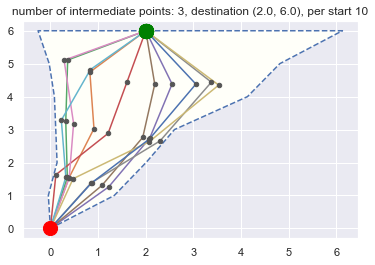

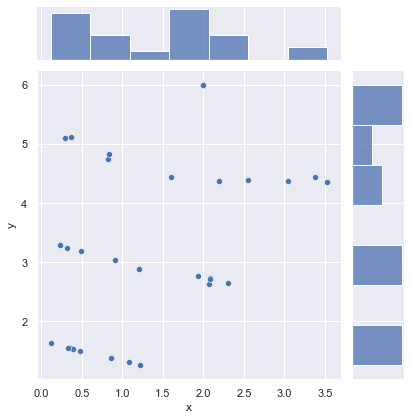

In [8]:
random.seed(39)
nIntermediate = 3
trajPerStart = 10
maxAbsDegree = 60
maxDeltaDegree = 45
nStartPoints = 5
startPoint = Point(0,0)
endPoint = Point(2, 6)

data, trajectories = sampler(
    
    areaPolygon = indDPolygon,
    goalLine = goalLine,
    startLine = startLine,
    
    latDirectionChangeProb = 0.3,
    nIntermediate = nIntermediate, 
    trajPerStart = trajPerStart, 
    maxAbsDegree = maxAbsDegree, 
    maxDeltaDegree = maxDeltaDegree,
    nStartPoints = nStartPoints,
    endPoint = endPoint, 
    startPoint = startPoint
)

In [9]:
# coverage tests
# # first get the min, max of X at y. Then order Y.
# print(f"number of intermediate points: {nIntermediate}, no destination, per start {trajPerStart}")
# trajEnvelope = getPolygonFromTrajectories(trajectories)
# plotPoly(trajEnvelope)
# areaCoverage, outOfBoundArea = getIOUAreasPercentage(indDPolygon, trajEnvelope)
# print(f"Area coverage {areaCoverage}%")
# print(f"Out of bound {outOfBoundArea}%")

##### nIntermediate = 5
trajPerStart = 3
maxAbsDegree = 60
maxDeltaDegree = 45
nStartPoints = 10

data, trajectories = sampler(
    
    areaPolygon = indDPolygon,
    goalLine = goalLine,
    startLine = startLine,
    
    latDirectionChangeProb = 0.3,
    nIntermediate = nIntermediate, 
    trajPerStart = trajPerStart, 
    maxAbsDegree = maxAbsDegree, 
    maxDeltaDegree = maxDeltaDegree,
    nStartPoints = nStartPoints,
    nEndPoints = None
)


In [10]:
inDConfigurations = [
    {
        "roadWidth": 6.0,
        "goalLine": LineString([[-0.2596540243344858, 6.0], [6.124331131277936, 6.0]]),
        "areaPolygon": Polygon([[-0.04379866275952693, 1.0], [0.1392774027998387, 2.0], [0.11232926309717928, 3.0], [0.08362071743614408, 4.0], [-0.025493044881786275, 5.0], [-0.2596540243344858, 6.0], [6.124331131277936, 6.0], [4.810796759574492, 5.0], [4.133177762335055, 4.0], [2.601473983049212, 3.0], [2.006487560127159, 2.0], [1.3391571002315772, 1.0], [-0.04379866275952693, 1.0]]),
        "startLine": LineString([[-0.04379866275952693, 1.0], [1.3391571002315772, 1.0]]),
        "idealDestination": Point([2,6])
    }
]
inDData = {
    "5.0": [
        [[-0.8493564206776597, 1.0], [-1.69111385831398, 2.0], [-2.315485015381113, 3.0], [-2.8998445021191133, 4.0], [-3.329996733382468, 5.0], [3.179880832919363, 5.0], [2.8579449043879515, 4.0], [2.407998876533319, 3.0], [1.8191770139055718, 2.0], [1.0923319480181632, 1.0], [-0.8493564206776597, 1.0]], 
        
    ], 
    "9.0": [
        [[-0.41374192554544376, 1.0], [-0.12175127345425274, 2.0], [0.4379053601341596, 3.0], [1.0001437331726877, 4.0], [1.3989329344162122, 5.0], [1.6242885571966426, 6.0], [1.8427370994859213, 7.0], [2.261074977665251, 8.0], [2.6342552510500847, 9.0], [11.978330982467018, 9.0], [9.242667289512717, 8.0], [7.9410026387656485, 7.0], [6.529691205716137, 6.0], [5.421111066704853, 5.0], [4.840944594280318, 4.0], [4.189429048085943, 3.0], [3.3998644585144078, 2.0], [2.593056063800949, 1.0], [-0.41374192554544376, 1.0]]
    ], 
    "6.0": [
        [[-0.04379866275952693, 1.0], [0.1392774027998387, 2.0], [0.11232926309717928, 3.0], [0.08362071743614408, 4.0], [-0.025493044881786275, 5.0], [-0.2596540243344858, 6.0], [6.124331131277936, 6.0], [4.810796759574492, 5.0], [4.133177762335055, 4.0], [2.601473983049212, 3.0], [2.006487560127159, 2.0], [1.3391571002315772, 1.0], [-0.04379866275952693, 1.0]], 
        [[-0.7840894965588592, 1.0], [-1.527932577432889, 2.0], [-2.3447542901070735, 3.0], [-3.2895142966539876, 4.0], [-4.284902413230908, 5.0], [-5.2184637903923985, 6.0], [5.254372472034417, 6.0], [3.7896178561042264, 5.0], [2.8387032358790076, 4.0], [2.1468062200572158, 3.0], [1.6182939774434928, 2.0], [0.9637181447460508, 1.0], [-0.7840894965588592, 1.0]], 
        [[-0.35403559323107503, 1.0], [-0.6349895672795756, 2.0], [-0.8943569063887107, 3.0], [-1.1771108033399367, 4.0], [-1.3643359057735231, 5.0], [-1.450887893345346, 6.0], [4.607294970255896, 6.0], [5.068896784716372, 5.0], [4.291985868250096, 4.0], [3.389357755785891, 3.0], [2.4978911227391567, 2.0], [1.4704225783642637, 1.0], [-0.35403559323107503, 1.0]]
    ]}
nPolygons = 0
for roadWidth in inDData:
    polygons = inDData[roadWidth]
    for poly in polygons:
        #start and goal line generation.
        yToX = defaultdict(lambda: [])
        for pos in poly:
            yToX[pos[1]].append(pos[0])
            
        maxY = max(yToX.keys())
        goalLine = LineString([[min(yToX[maxY]), maxY], [max(yToX[maxY]), maxY]])
        print("goalLine", goalLine.xy)
        
        minY = min(yToX.keys())
        startLine = LineString([[min(yToX[minY]), minY], [max(yToX[minY]), minY]])
        # print("startLine", startLine.xy)
        
        # we are gonna inject the 0,0 to each polygon
        # the first and the last points are 0, 0
        poly.insert(0, [0,0])
        poly[-1] = [0,0]
        areaPolygon = Polygon(poly)
        
        conf = {
            "roadWidth": roadWidth,
            "goalLine": goalLine,
            "areaPolygon": areaPolygon,
            "startLine": startLine
            
        }
        inDConfigurations.append(conf)
        nPolygons += 1

goalLine (array('d', [-3.329996733382468, 3.179880832919363]), array('d', [5.0, 5.0]))
goalLine (array('d', [2.6342552510500847, 11.978330982467018]), array('d', [9.0, 9.0]))
goalLine (array('d', [-0.2596540243344858, 6.124331131277936]), array('d', [6.0, 6.0]))
goalLine (array('d', [-5.2184637903923985, 5.254372472034417]), array('d', [6.0, 6.0]))
goalLine (array('d', [-1.450887893345346, 4.607294970255896]), array('d', [6.0, 6.0]))


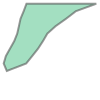

In [11]:
# print(inDConfigurations[1])
inDConfigurations[2]["areaPolygon"]

In [12]:
# Data for one source 5 destination
# random.seed(39)
# nIntermediate = 2
# trajPerStart = 500
# maxAbsDegree = 60
# maxDeltaDegree = 45
# nStartPoints = 1
# startPoint = Point(0,0)
# nEndPoints = 5
# endPoint = None
# inDConf = inDConfigurations[3]

# data, trajectories5Dest = sampler(

#     areaPolygon = inDConf["areaPolygon"],
#     goalLine = inDConf["goalLine"],
#     startLine = inDConf["startLine"],

#     latDirectionChangeProb = 0.2,
#     nIntermediate = nIntermediate, 
#     trajPerStart = trajPerStart, 
#     maxAbsDegree = maxAbsDegree, 
#     maxDeltaDegree = maxDeltaDegree,
#     nStartPoints = nStartPoints,
#     startPoint = startPoint,
#     nEndPoints = nEndPoints,
#     endPoint = endPoint,
#     plot=True
# )

# print(f"Road width {roadWidth}, number of intermediate points: {nIntermediate}, destination {endPoint.x, endPoint.y}, per start {trajPerStart}")
# trajEnvelope = getPolygonFromTrajectories(trajectories)
# # plotPoly(trajEnvelope)
# areaCoverage, outOfBoundArea = getIOUAreasPercentage(inDConf["areaPolygon"], trajEnvelope)
# print(f"Area coverage {areaCoverage}%")
# print(f"Out of bound {outOfBoundArea}%")

In [13]:
# maxLinearDistance = startPoint.distance(Point(6,6))
# routeLengthHistogram(trajectories5Dest, maxLinearDistance)

In [14]:
# heatmap(trajectories5Dest, "X", "Y")

In [15]:
# Data for single pair of source destination in one polygon
# random.seed(39)
# nIntermediate = 2
# trajPerStart = 500
# maxAbsDegree = 60
# maxDeltaDegree = 45
# nStartPoints = 1
# startPoint = Point(0,0)
# endPoint = Point(2, 6)
# inDConf = inDConfigurations[3]

# data, trajectoriesSourceDestPair = sampler(

#     areaPolygon = inDConf["areaPolygon"],
#     goalLine = inDConf["goalLine"],
#     startLine = inDConf["startLine"],

#     latDirectionChangeProb = 0.2,
#     nIntermediate = nIntermediate, 
#     trajPerStart = trajPerStart, 
#     maxAbsDegree = maxAbsDegree, 
#     maxDeltaDegree = maxDeltaDegree,
#     nStartPoints = nStartPoints,
#     startPoint = startPoint,
#     nEndPoints = nEndPoints,
#     endPoint = endPoint,
#     plot=True
# )

# print(f"Road width {roadWidth}, number of intermediate points: {nIntermediate}, destination {endPoint.x, endPoint.y}, per start {trajPerStart}")
# # trajEnvelope = getPolygonFromTrajectories(trajectories)
# # # plotPoly(trajEnvelope)
# # areaCoverage, outOfBoundArea = getIOUAreasPercentage(inDConf["areaPolygon"], trajEnvelope)
# # print(f"Area coverage {areaCoverage}%")
# # print(f"Out of bound {outOfBoundArea}%")



In [16]:
from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from tti_dataset_tools.ColMapper import ColMapper
from tti_dataset_tools import RegularKnotsModel
from tti_dataset_tools import CrosswalkModel
visualizer = TrajectoryVisualizer()
colMapper = ColMapper(
        idCol='id', 
        xCol='X', 
        yCol='Y',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed',
        fps=0,
        localXCol='X',
        localYCol='Y',
    )
colMapperInD = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity', 
        speedCol='speed',
        fps=0,
        localXCol='localX',
        localYCol='localY',
    )
transformer = TrajectoryTransformer(colMapper)
crosswalkModel = CrosswalkModel(colMapper)
regKnotsModel = RegularKnotsModel(colMapper)
regKnotsModelInD = RegularKnotsModel(colMapperInD)

In [17]:
# InD scene 30 north peds
northPeds = pd.read_csv("./notebooks/Crosswalk-area/northPeds-scene-30")

In [18]:
sns.set(font_scale=3)
plt.figure(figsize=(10, 7))

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

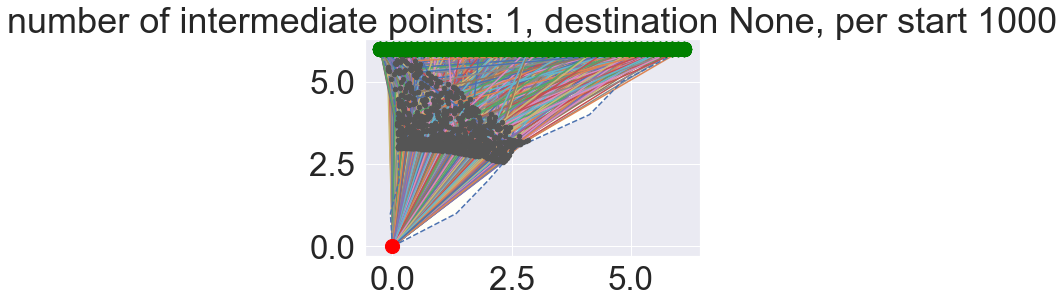

C:\Users\adhocmaster\anaconda3\envs\carla37\lib\site-packages\seaborn\axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


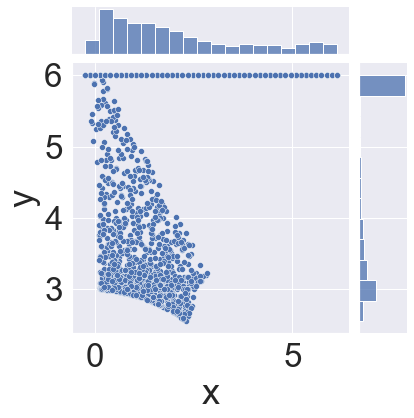

In [19]:
# Data for one source 5 destination, 1 intermediatePoint
random.seed(39)
nIntermediate = 1
trajPerStart = 1000
maxAbsDegree = 60
maxDeltaDegree = 45
nStartPoints = 1
startPoint = Point(0,0)
nEndPoints = 50
endPoint = None
inDConf = inDConfigurations[3]

data, trajectories1WP = sampler(

    areaPolygon = inDConf["areaPolygon"],
    goalLine = inDConf["goalLine"],
    startLine = inDConf["startLine"],

    latDirectionChangeProb = 0.2,
    nIntermediate = nIntermediate, 
    trajPerStart = trajPerStart, 
    maxAbsDegree = maxAbsDegree, 
    maxDeltaDegree = maxDeltaDegree,
    nStartPoints = nStartPoints,
    startPoint = startPoint,
    nEndPoints = nEndPoints,
    endPoint = endPoint,
    plot=True
)


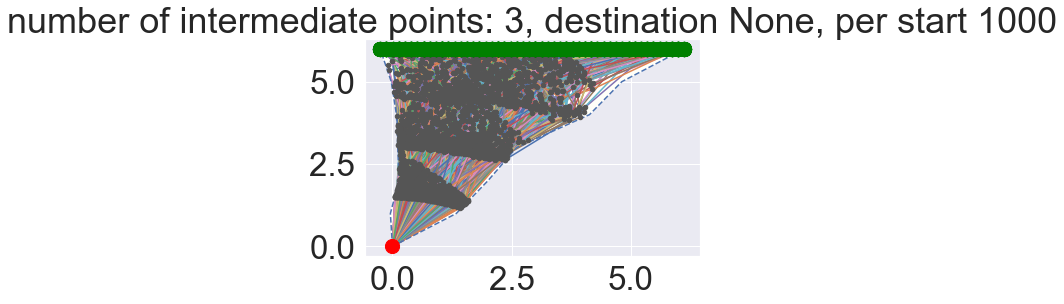

C:\Users\adhocmaster\anaconda3\envs\carla37\lib\site-packages\seaborn\axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


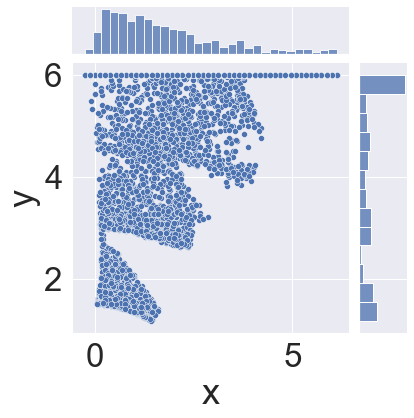

In [20]:
# Data for one source 5 destination, 1 intermediatePoint
random.seed(39)
nIntermediate = 3
trajPerStart = 1000
maxAbsDegree = 60
maxDeltaDegree = 45
nStartPoints = 1
startPoint = Point(0,0)
nEndPoints = 50
endPoint = None
inDConf = inDConfigurations[3]

data, trajectories3WP = sampler(

    areaPolygon = inDConf["areaPolygon"],
    goalLine = inDConf["goalLine"],
    startLine = inDConf["startLine"],

    latDirectionChangeProb = 0.2,
    nIntermediate = nIntermediate, 
    trajPerStart = trajPerStart, 
    maxAbsDegree = maxAbsDegree, 
    maxDeltaDegree = maxDeltaDegree,
    nStartPoints = nStartPoints,
    startPoint = startPoint,
    nEndPoints = nEndPoints,
    endPoint = endPoint,
    plot=True
)


In [21]:
# convert trajectories to dataframe
def convertTrajsToDf(trajectories: List[List[Point]]) -> pd.DataFrame:
    X = []
    Y = []
    idCol = []
    count = 0
    for traj in trajectories:
        count += 1
        for point in traj:
            idCol.append(count)
            X.append(point.x)
            Y.append(point.y)

    df = pd.DataFrame({"id": idCol, "X":X, "Y": Y})
    return df


(-4.0, 4.0)

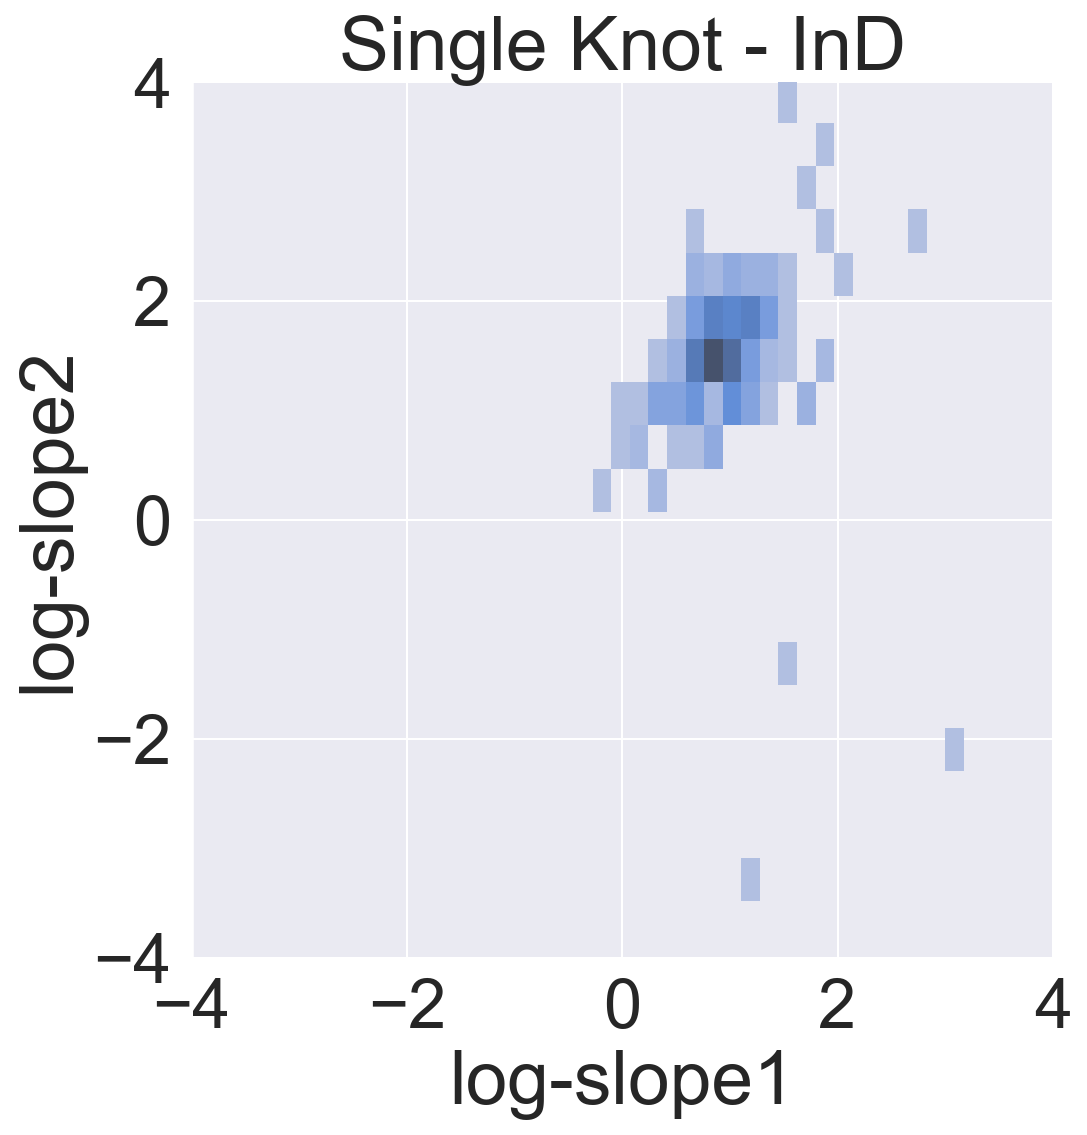

In [55]:
knotDfInd1 = regKnotsModelInD.getSingleKnotData(northPeds, midY=3.0, midYTolerance=1, plot=False)
sns.displot(knotDfInd1, x="log-slope1", y="log-slope2", height=8, bins=20)
plt.title("Single Knot - InD")
plt.ylim(-4, 4)
plt.xlim(-4, 4)

In [23]:
df1 = convertTrajsToDf(trajectories1WP)
knotDf1 = regKnotsModel.getSingleKnotData(df1, midY=3.0, midYTolerance=1, plot=False, ignoreBads=True)

Set debug=True to see the errors.


In [24]:
# knotDf1.head()

(-4.0, 4.0)

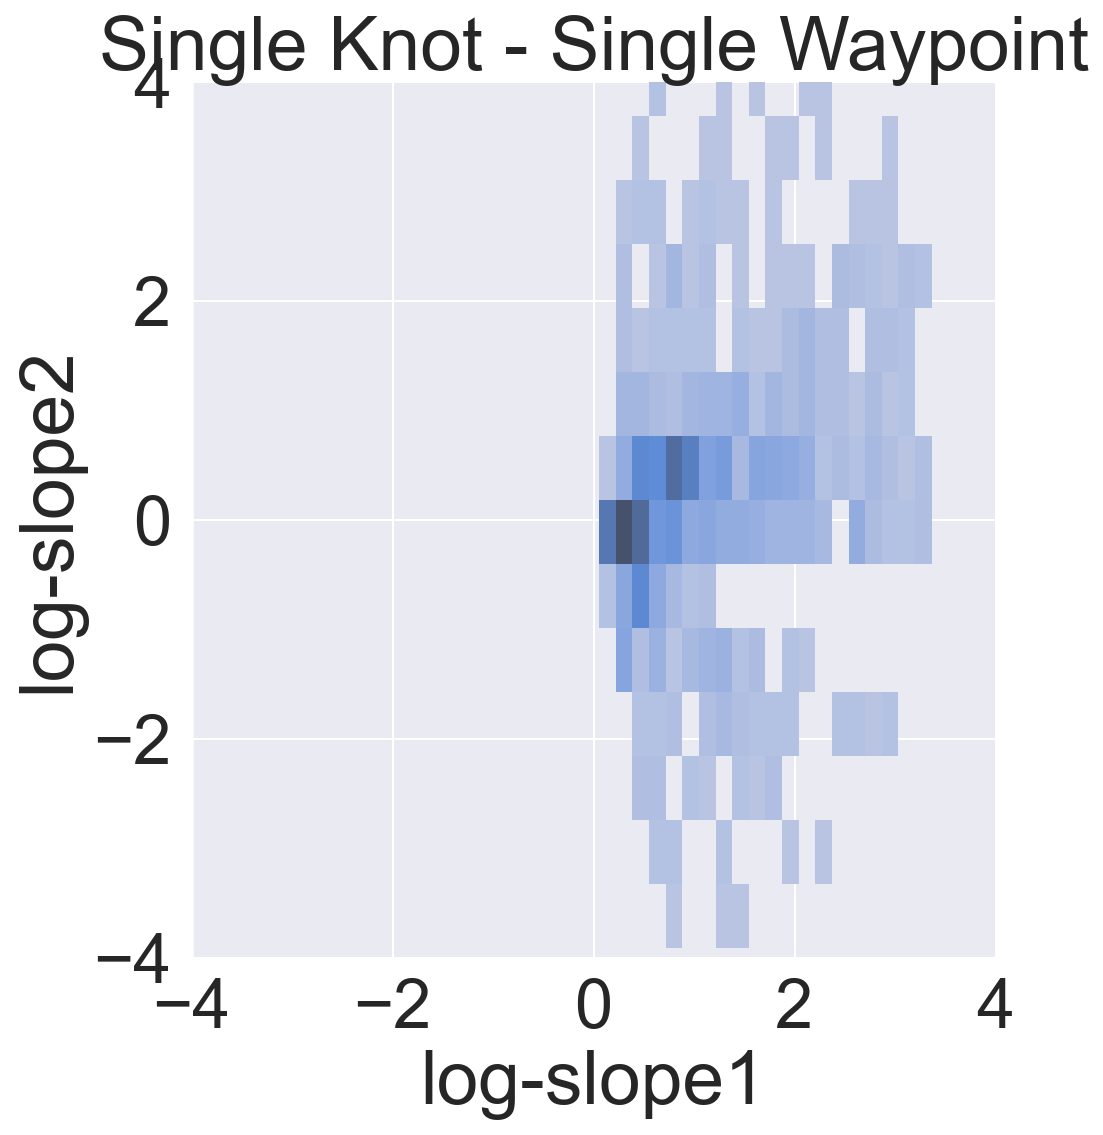

In [52]:
sns.displot(knotDf1, x="log-slope1", y="log-slope2", height=8, bins=20)
plt.title("Single Knot - Single Waypoint")
# plt.ylim(-6.2, 6.2)

plt.xlim(-4, 4)
plt.xticks(range(-4, 4+1, 2))
plt.ylim(-4, 4)

In [27]:
df2 = convertTrajsToDf(trajectories3WP)
knotDf2 = regKnotsModel.getSingleKnotData(df2, midY=3.0, midYTolerance=1, plot=False, ignoreBads=True)

Set debug=True to see the errors.


In [28]:
knotDf2.head()

,id,midX,midY,finalX,finalY,log-slope1,log-slope2
0,1,1.550682,3.0,-0.129369,6.0,0.659918,-0.579788
1,2,0.954810,3.0,3.258052,6.0,1.144855,0.264295
2,3,0.252593,3.0,1.955198,6.0,2.474587,0.566453
3,4,2.041390,3.0,0.652344,6.0,0.384981,-0.769995
4,5,0.267583,3.0,1.043200,6.0,2.416937,1.352709


([<matplotlib.axis.XTick at 0x25a1ac8d508>,
 [Text(-2.0, 0, '−2'),
  Text(0.0, 0, '0'),
  Text(2.0, 0, '2'),
  Text(4.0, 0, '4'),
  Text(1.0, 0, '1.00')])

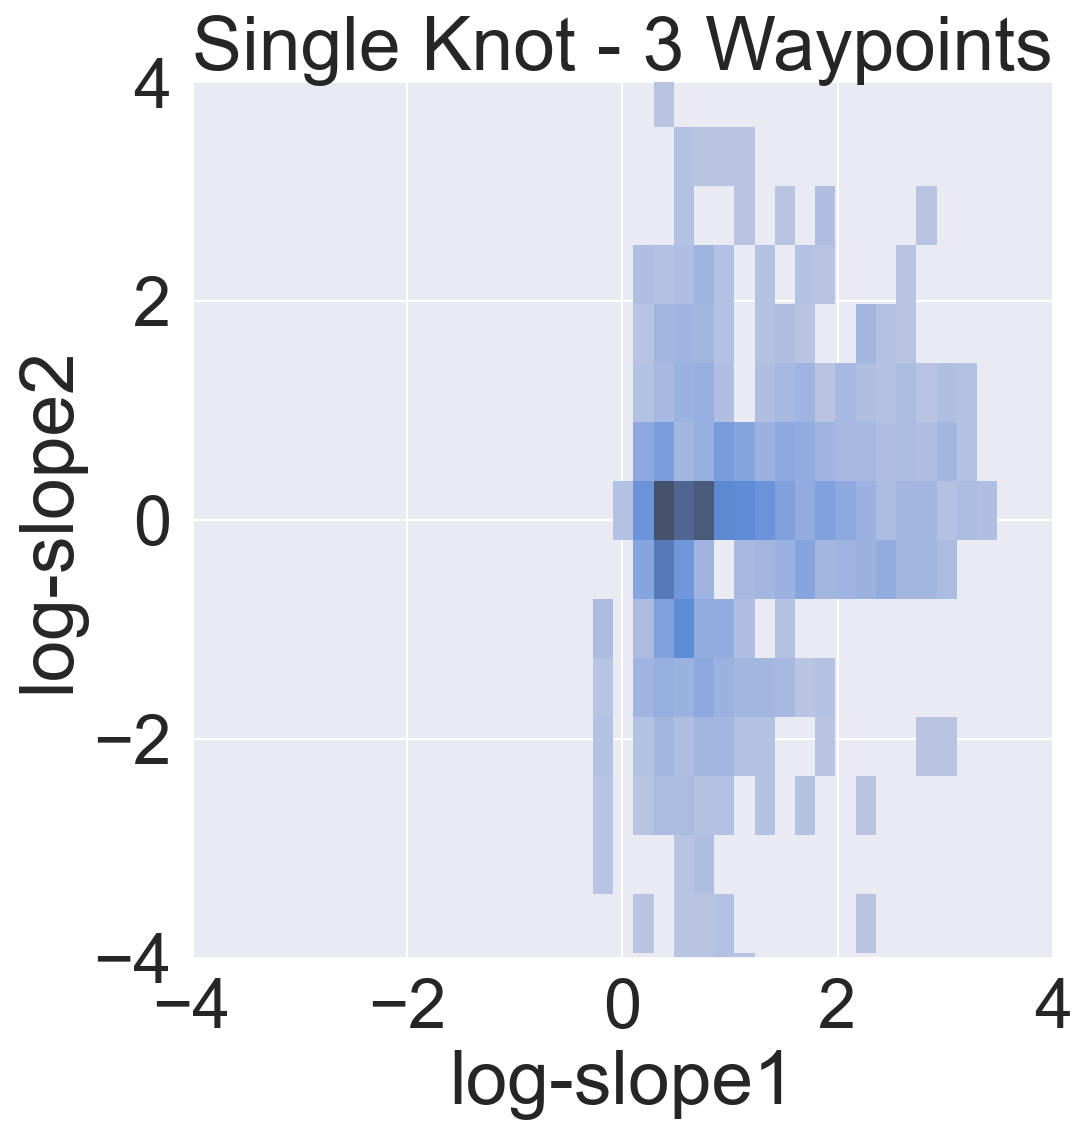

In [53]:
plt.rcParams['figure.dpi'] = 150
sns.displot(knotDf2, x="log-slope1", y="log-slope2", height=8, bins=20)
plt.title("Single Knot - 3 Waypoints")
plt.ylim(-4, 4)
plt.xlim(-4, 4)
plt.xticks(range(-4, 4+1, 2))

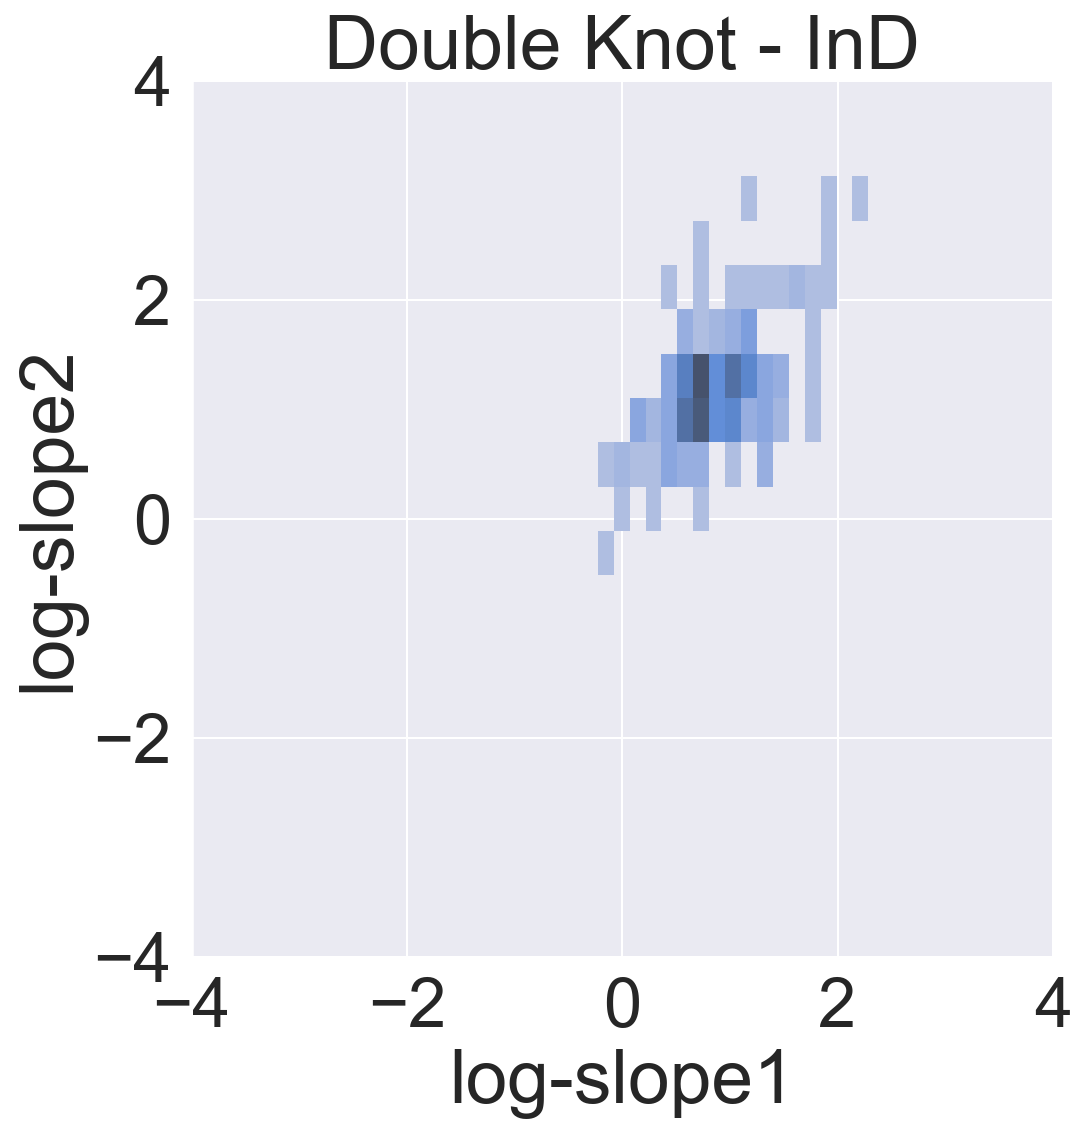

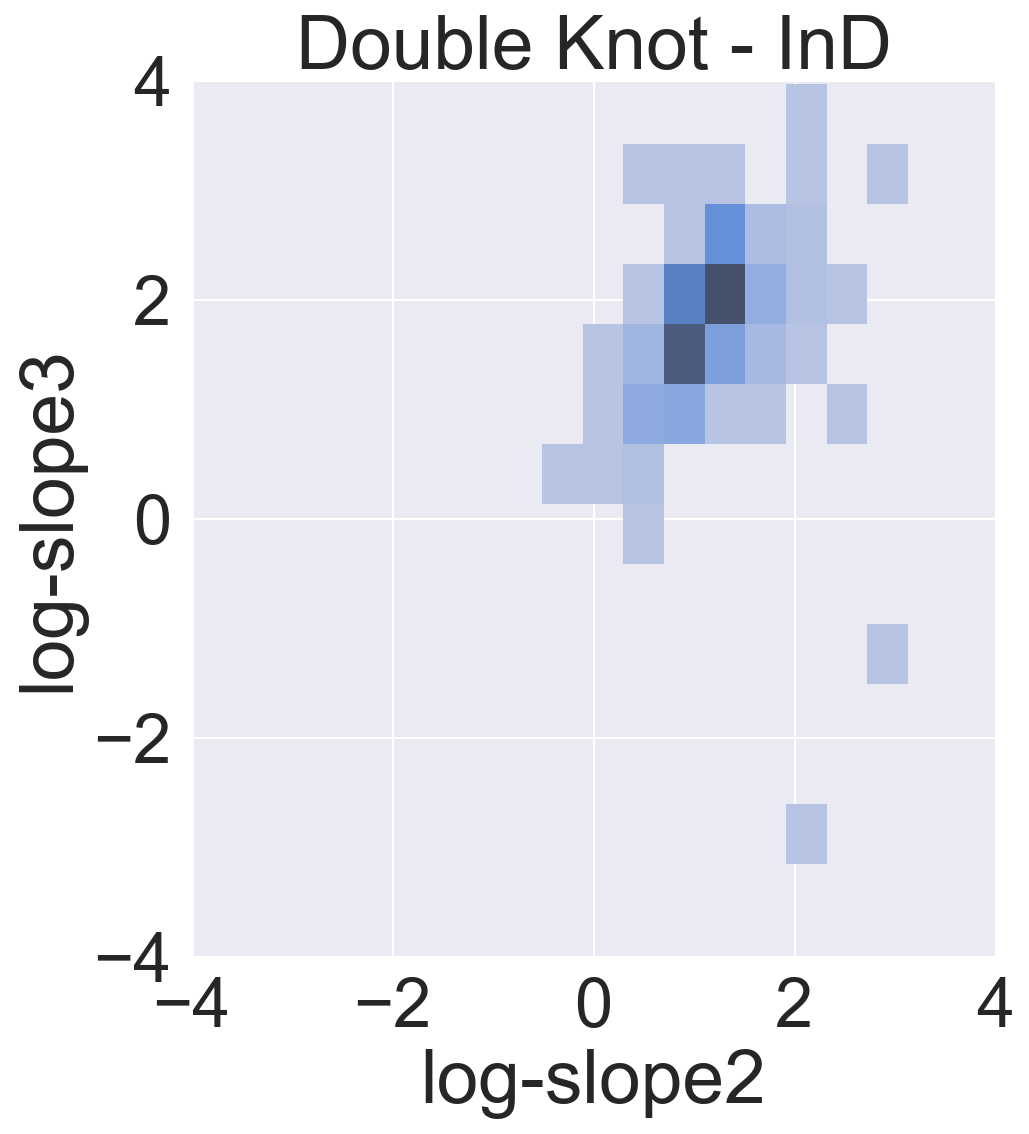

In [54]:
knotDfInD2 = regKnotsModelInD.getKnotData(northPeds, yBreakpoints=[2.0, 4.0], yTolerance=1, plot=False)
sns.displot(knotDfInD2, x="log-slope1", y="log-slope2", height=8, bins=20)
plt.title("Double Knot - InD")
plt.ylim(-4, 4)
plt.xlim(-4, 4)
plt.show()
sns.displot(knotDfInD2, x="log-slope2", y="log-slope3", height=8, bins=20)
plt.title("Double Knot - InD")
plt.ylim(-4, 4)
plt.xlim(-4, 4)
plt.xticks(range(-4, 4+1, 2))
plt.show()

In [40]:
# df2 = convertTrajsToDf(trajectories3WP)
knotDf3 = regKnotsModel.getKnotData(df2, yBreakpoints=[2.0, 4.0], yTolerance=1, plot=False, ignoreBads=True)

Set debug=True to see the errors.


(-4.0, 4.0)

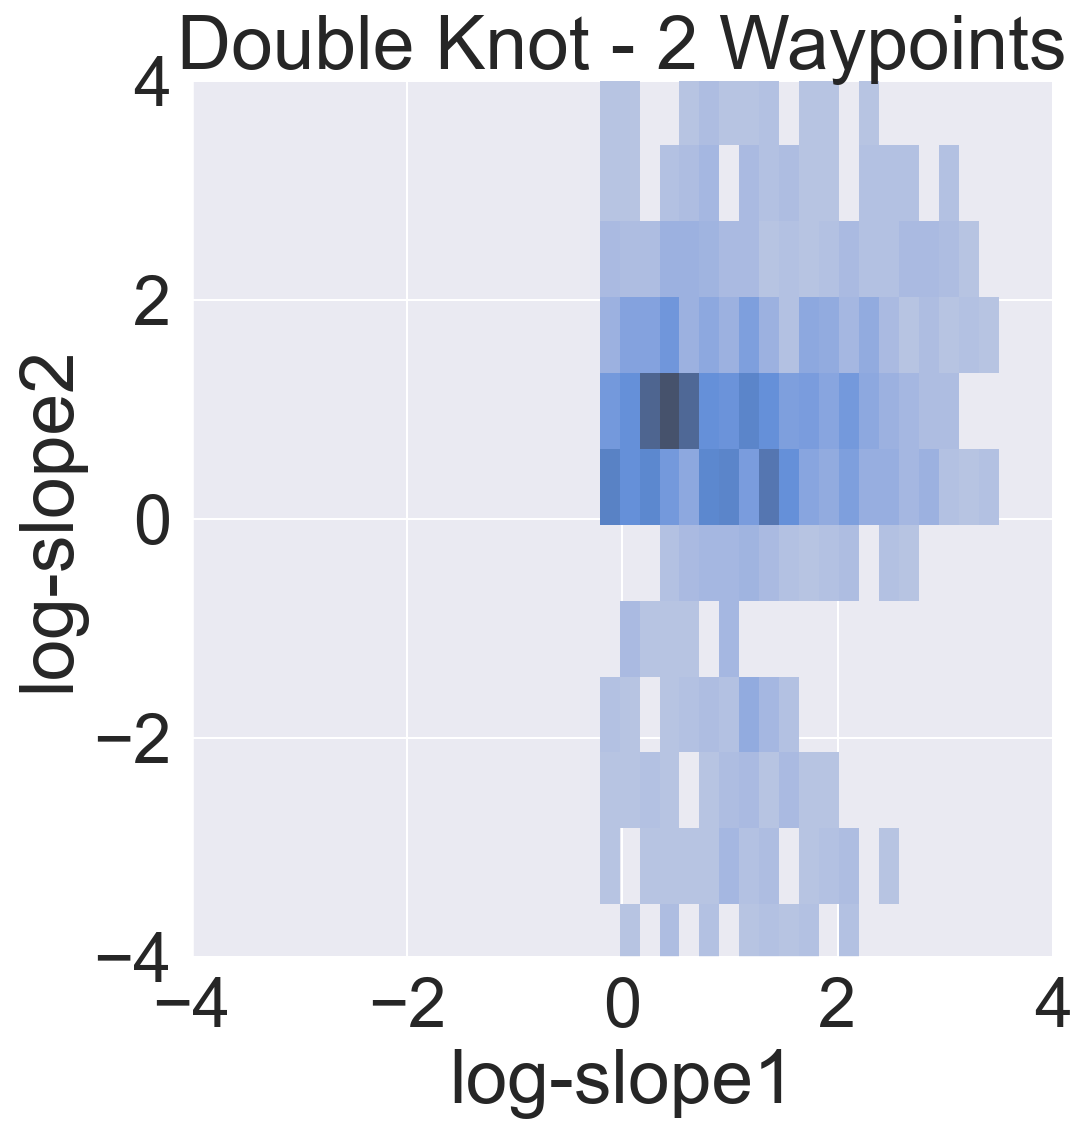

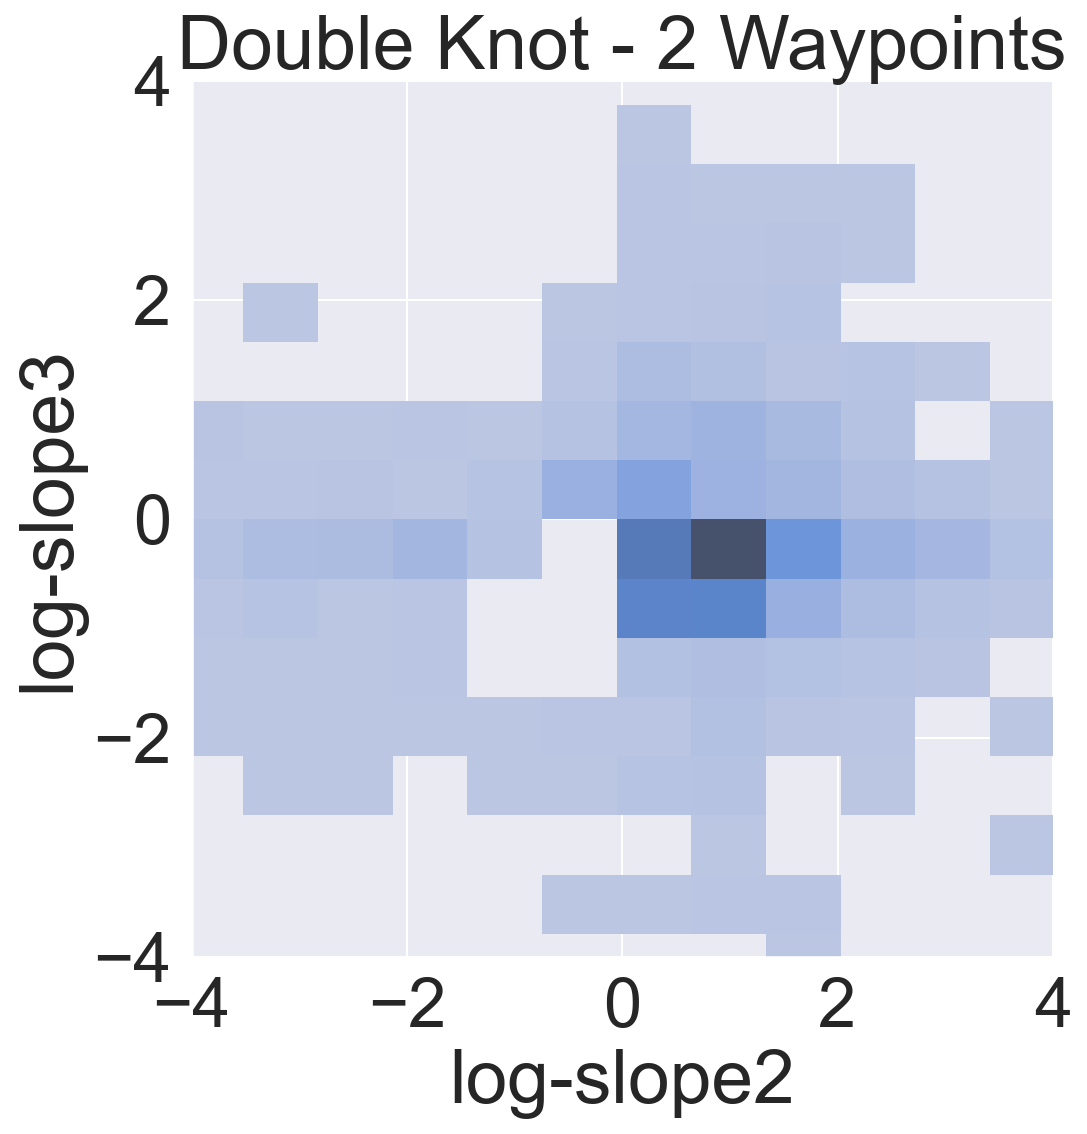

In [41]:
sns.displot(knotDf3, x="log-slope1", y="log-slope2", height=8, bins=20)
plt.title("Double Knot - 2 Waypoints")
plt.ylim(-4, 4)
plt.xlim(-4, 4)
sns.displot(knotDf3, x="log-slope2", y="log-slope3", height=8, bins=20)
plt.title("Double Knot - 2 Waypoints")
plt.ylim(-4, 4)
plt.xlim(-4, 4)